In [8]:
source_folder = '../Data/Processed/'
destination_folder = '../Data/Processed/LSTM'

In [9]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
# Fields

id_field = Field(sequential=False, use_vocab=False, batch_first=True,dtype=torch.int)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('target', label_field),('text', text_field),('id', id_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [12]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [13]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [14]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len), ids), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (text, text_len), ids),_ in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        text_len = text_len.to(device)
                        output = model(text, text_len)
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [32]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [83/1670], Train Loss: 0.6595, Valid Loss: 0.6152
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [1/10], Step [166/1670], Train Loss: 0.6044, Valid Loss: 0.5513
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [2/10], Step [249/1670], Train Loss: 0.4845, Valid Loss: 0.5158
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [2/10], Step [332/1670], Train Loss: 0.4471, Valid Loss: 0.5038
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [3/10], Step [415/1670], Train Loss: 0.3461, Valid Loss: 0.5017
Model saved to ==> ../Data/Processed/LSTM/model.pt
Model saved to ==> ../Data/Processed/LSTM/metrics.pt
Epoch [3/10], Step [498/1670], Train Loss: 0.3142, Valid Loss: 0.5446
Epoch [4/10], Step [581/1670], Train Loss: 0.2405, Valid Loss

Model loaded from <== ../Data/Processed/metrics.pt


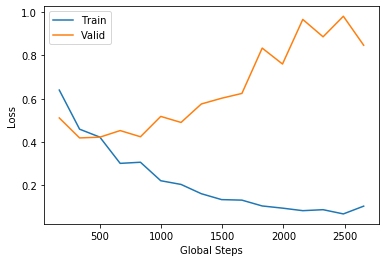

In [33]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [34]:
from datetime import datetime
def evaluate_to_df(model, test_loader, threshold=0.5):
    y_pred = []
    y_id = []

    model.eval()
    with torch.no_grad():
        for ((text, text_len),idn), _ in test_loader:     
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_id.extend(idn.tolist())
    submission_df = pd.DataFrame()
    submission_df['prediction'] = y_pred
    submission_df['id'] = y_id
    return submission_df

In [35]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.0005)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)

Model loaded from <== ../Data/Processed/model.pt


RuntimeError: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "embedding.weight", "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "lstm.weight_ih_l0_reverse", "lstm.weight_hh_l0_reverse", "lstm.bias_ih_l0_reverse", "lstm.bias_hh_l0_reverse", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "encoder.bert.embeddings.word_embeddings.weight", "encoder.bert.embeddings.position_embeddings.weight", "encoder.bert.embeddings.token_type_embeddings.weight", "encoder.bert.embeddings.LayerNorm.weight", "encoder.bert.embeddings.LayerNorm.bias", "encoder.bert.encoder.layer.0.attention.self.query.weight", "encoder.bert.encoder.layer.0.attention.self.query.bias", "encoder.bert.encoder.layer.0.attention.self.key.weight", "encoder.bert.encoder.layer.0.attention.self.key.bias", "encoder.bert.encoder.layer.0.attention.self.value.weight", "encoder.bert.encoder.layer.0.attention.self.value.bias", "encoder.bert.encoder.layer.0.attention.output.dense.weight", "encoder.bert.encoder.layer.0.attention.output.dense.bias", "encoder.bert.encoder.layer.0.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.0.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.0.intermediate.dense.weight", "encoder.bert.encoder.layer.0.intermediate.dense.bias", "encoder.bert.encoder.layer.0.output.dense.weight", "encoder.bert.encoder.layer.0.output.dense.bias", "encoder.bert.encoder.layer.0.output.LayerNorm.weight", "encoder.bert.encoder.layer.0.output.LayerNorm.bias", "encoder.bert.encoder.layer.1.attention.self.query.weight", "encoder.bert.encoder.layer.1.attention.self.query.bias", "encoder.bert.encoder.layer.1.attention.self.key.weight", "encoder.bert.encoder.layer.1.attention.self.key.bias", "encoder.bert.encoder.layer.1.attention.self.value.weight", "encoder.bert.encoder.layer.1.attention.self.value.bias", "encoder.bert.encoder.layer.1.attention.output.dense.weight", "encoder.bert.encoder.layer.1.attention.output.dense.bias", "encoder.bert.encoder.layer.1.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.1.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.1.intermediate.dense.weight", "encoder.bert.encoder.layer.1.intermediate.dense.bias", "encoder.bert.encoder.layer.1.output.dense.weight", "encoder.bert.encoder.layer.1.output.dense.bias", "encoder.bert.encoder.layer.1.output.LayerNorm.weight", "encoder.bert.encoder.layer.1.output.LayerNorm.bias", "encoder.bert.encoder.layer.2.attention.self.query.weight", "encoder.bert.encoder.layer.2.attention.self.query.bias", "encoder.bert.encoder.layer.2.attention.self.key.weight", "encoder.bert.encoder.layer.2.attention.self.key.bias", "encoder.bert.encoder.layer.2.attention.self.value.weight", "encoder.bert.encoder.layer.2.attention.self.value.bias", "encoder.bert.encoder.layer.2.attention.output.dense.weight", "encoder.bert.encoder.layer.2.attention.output.dense.bias", "encoder.bert.encoder.layer.2.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.2.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.2.intermediate.dense.weight", "encoder.bert.encoder.layer.2.intermediate.dense.bias", "encoder.bert.encoder.layer.2.output.dense.weight", "encoder.bert.encoder.layer.2.output.dense.bias", "encoder.bert.encoder.layer.2.output.LayerNorm.weight", "encoder.bert.encoder.layer.2.output.LayerNorm.bias", "encoder.bert.encoder.layer.3.attention.self.query.weight", "encoder.bert.encoder.layer.3.attention.self.query.bias", "encoder.bert.encoder.layer.3.attention.self.key.weight", "encoder.bert.encoder.layer.3.attention.self.key.bias", "encoder.bert.encoder.layer.3.attention.self.value.weight", "encoder.bert.encoder.layer.3.attention.self.value.bias", "encoder.bert.encoder.layer.3.attention.output.dense.weight", "encoder.bert.encoder.layer.3.attention.output.dense.bias", "encoder.bert.encoder.layer.3.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.3.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.3.intermediate.dense.weight", "encoder.bert.encoder.layer.3.intermediate.dense.bias", "encoder.bert.encoder.layer.3.output.dense.weight", "encoder.bert.encoder.layer.3.output.dense.bias", "encoder.bert.encoder.layer.3.output.LayerNorm.weight", "encoder.bert.encoder.layer.3.output.LayerNorm.bias", "encoder.bert.encoder.layer.4.attention.self.query.weight", "encoder.bert.encoder.layer.4.attention.self.query.bias", "encoder.bert.encoder.layer.4.attention.self.key.weight", "encoder.bert.encoder.layer.4.attention.self.key.bias", "encoder.bert.encoder.layer.4.attention.self.value.weight", "encoder.bert.encoder.layer.4.attention.self.value.bias", "encoder.bert.encoder.layer.4.attention.output.dense.weight", "encoder.bert.encoder.layer.4.attention.output.dense.bias", "encoder.bert.encoder.layer.4.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.4.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.4.intermediate.dense.weight", "encoder.bert.encoder.layer.4.intermediate.dense.bias", "encoder.bert.encoder.layer.4.output.dense.weight", "encoder.bert.encoder.layer.4.output.dense.bias", "encoder.bert.encoder.layer.4.output.LayerNorm.weight", "encoder.bert.encoder.layer.4.output.LayerNorm.bias", "encoder.bert.encoder.layer.5.attention.self.query.weight", "encoder.bert.encoder.layer.5.attention.self.query.bias", "encoder.bert.encoder.layer.5.attention.self.key.weight", "encoder.bert.encoder.layer.5.attention.self.key.bias", "encoder.bert.encoder.layer.5.attention.self.value.weight", "encoder.bert.encoder.layer.5.attention.self.value.bias", "encoder.bert.encoder.layer.5.attention.output.dense.weight", "encoder.bert.encoder.layer.5.attention.output.dense.bias", "encoder.bert.encoder.layer.5.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.5.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.5.intermediate.dense.weight", "encoder.bert.encoder.layer.5.intermediate.dense.bias", "encoder.bert.encoder.layer.5.output.dense.weight", "encoder.bert.encoder.layer.5.output.dense.bias", "encoder.bert.encoder.layer.5.output.LayerNorm.weight", "encoder.bert.encoder.layer.5.output.LayerNorm.bias", "encoder.bert.encoder.layer.6.attention.self.query.weight", "encoder.bert.encoder.layer.6.attention.self.query.bias", "encoder.bert.encoder.layer.6.attention.self.key.weight", "encoder.bert.encoder.layer.6.attention.self.key.bias", "encoder.bert.encoder.layer.6.attention.self.value.weight", "encoder.bert.encoder.layer.6.attention.self.value.bias", "encoder.bert.encoder.layer.6.attention.output.dense.weight", "encoder.bert.encoder.layer.6.attention.output.dense.bias", "encoder.bert.encoder.layer.6.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.6.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.6.intermediate.dense.weight", "encoder.bert.encoder.layer.6.intermediate.dense.bias", "encoder.bert.encoder.layer.6.output.dense.weight", "encoder.bert.encoder.layer.6.output.dense.bias", "encoder.bert.encoder.layer.6.output.LayerNorm.weight", "encoder.bert.encoder.layer.6.output.LayerNorm.bias", "encoder.bert.encoder.layer.7.attention.self.query.weight", "encoder.bert.encoder.layer.7.attention.self.query.bias", "encoder.bert.encoder.layer.7.attention.self.key.weight", "encoder.bert.encoder.layer.7.attention.self.key.bias", "encoder.bert.encoder.layer.7.attention.self.value.weight", "encoder.bert.encoder.layer.7.attention.self.value.bias", "encoder.bert.encoder.layer.7.attention.output.dense.weight", "encoder.bert.encoder.layer.7.attention.output.dense.bias", "encoder.bert.encoder.layer.7.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.7.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.7.intermediate.dense.weight", "encoder.bert.encoder.layer.7.intermediate.dense.bias", "encoder.bert.encoder.layer.7.output.dense.weight", "encoder.bert.encoder.layer.7.output.dense.bias", "encoder.bert.encoder.layer.7.output.LayerNorm.weight", "encoder.bert.encoder.layer.7.output.LayerNorm.bias", "encoder.bert.encoder.layer.8.attention.self.query.weight", "encoder.bert.encoder.layer.8.attention.self.query.bias", "encoder.bert.encoder.layer.8.attention.self.key.weight", "encoder.bert.encoder.layer.8.attention.self.key.bias", "encoder.bert.encoder.layer.8.attention.self.value.weight", "encoder.bert.encoder.layer.8.attention.self.value.bias", "encoder.bert.encoder.layer.8.attention.output.dense.weight", "encoder.bert.encoder.layer.8.attention.output.dense.bias", "encoder.bert.encoder.layer.8.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.8.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.8.intermediate.dense.weight", "encoder.bert.encoder.layer.8.intermediate.dense.bias", "encoder.bert.encoder.layer.8.output.dense.weight", "encoder.bert.encoder.layer.8.output.dense.bias", "encoder.bert.encoder.layer.8.output.LayerNorm.weight", "encoder.bert.encoder.layer.8.output.LayerNorm.bias", "encoder.bert.encoder.layer.9.attention.self.query.weight", "encoder.bert.encoder.layer.9.attention.self.query.bias", "encoder.bert.encoder.layer.9.attention.self.key.weight", "encoder.bert.encoder.layer.9.attention.self.key.bias", "encoder.bert.encoder.layer.9.attention.self.value.weight", "encoder.bert.encoder.layer.9.attention.self.value.bias", "encoder.bert.encoder.layer.9.attention.output.dense.weight", "encoder.bert.encoder.layer.9.attention.output.dense.bias", "encoder.bert.encoder.layer.9.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.9.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.9.intermediate.dense.weight", "encoder.bert.encoder.layer.9.intermediate.dense.bias", "encoder.bert.encoder.layer.9.output.dense.weight", "encoder.bert.encoder.layer.9.output.dense.bias", "encoder.bert.encoder.layer.9.output.LayerNorm.weight", "encoder.bert.encoder.layer.9.output.LayerNorm.bias", "encoder.bert.encoder.layer.10.attention.self.query.weight", "encoder.bert.encoder.layer.10.attention.self.query.bias", "encoder.bert.encoder.layer.10.attention.self.key.weight", "encoder.bert.encoder.layer.10.attention.self.key.bias", "encoder.bert.encoder.layer.10.attention.self.value.weight", "encoder.bert.encoder.layer.10.attention.self.value.bias", "encoder.bert.encoder.layer.10.attention.output.dense.weight", "encoder.bert.encoder.layer.10.attention.output.dense.bias", "encoder.bert.encoder.layer.10.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.10.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.10.intermediate.dense.weight", "encoder.bert.encoder.layer.10.intermediate.dense.bias", "encoder.bert.encoder.layer.10.output.dense.weight", "encoder.bert.encoder.layer.10.output.dense.bias", "encoder.bert.encoder.layer.10.output.LayerNorm.weight", "encoder.bert.encoder.layer.10.output.LayerNorm.bias", "encoder.bert.encoder.layer.11.attention.self.query.weight", "encoder.bert.encoder.layer.11.attention.self.query.bias", "encoder.bert.encoder.layer.11.attention.self.key.weight", "encoder.bert.encoder.layer.11.attention.self.key.bias", "encoder.bert.encoder.layer.11.attention.self.value.weight", "encoder.bert.encoder.layer.11.attention.self.value.bias", "encoder.bert.encoder.layer.11.attention.output.dense.weight", "encoder.bert.encoder.layer.11.attention.output.dense.bias", "encoder.bert.encoder.layer.11.attention.output.LayerNorm.weight", "encoder.bert.encoder.layer.11.attention.output.LayerNorm.bias", "encoder.bert.encoder.layer.11.intermediate.dense.weight", "encoder.bert.encoder.layer.11.intermediate.dense.bias", "encoder.bert.encoder.layer.11.output.dense.weight", "encoder.bert.encoder.layer.11.output.dense.bias", "encoder.bert.encoder.layer.11.output.LayerNorm.weight", "encoder.bert.encoder.layer.11.output.LayerNorm.bias", "encoder.bert.pooler.dense.weight", "encoder.bert.pooler.dense.bias", "encoder.classifier.weight", "encoder.classifier.bias". 

In [19]:
destination_folder = '../Data/Processed'
test_raw = pd.read_csv('../Data/test.csv')
for i in range(16-len(test_raw)%16):
    newRow = pd.DataFrame({"id": [-1], "text" : ["NA"]})
    test_raw = test_raw.append(newRow)
test_raw = test_raw.reindex(columns=['text','id'])
test_raw.to_csv(destination_folder + '/test.csv', index=False)

C:\Users\JBKec\Anaconda3\envs\opencv\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [20]:
test_fields =[('text', text_field),('id', id_field)]
test_data = TabularDataset(path='../Data/Processed/test.csv', fields=test_fields, format='CSV', skip_header=True)

In [21]:
from torchtext.data import Iterator

test_iter = BucketIterator(test_data, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=False, sort_within_batch=True)

In [22]:
submission_df = evaluate_to_df(best_model, test_iter)

In [23]:
submission_df = submission_df[submission_df['id'] != -1]
submission_df = submission_df[['id','prediction']]
submission_df.columns = ['id', 'target']

In [24]:
submission_df = submission_df.sort_values('id')
submission_df.head()

,id,target
2231,0,1
1221,2,0
1606,3,0
2478,9,1
2630,11,1


In [25]:
submission_df.to_csv('../Data/Processed/LSTM/LSTMSubmission.csv',index=False)